### Universidad del Valle de Guatemala
#### Brandon Ronaldo Sicay Cumes - 21757
##### Modelo base, métricas personalizadas, función optimización




## Modelo Base


In [3]:
%pip install lightgbm


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.6 MB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


### Dividir conjunto de datos (entrenamiento y)

In [6]:

# -----------------------------
# Preparación de datos
# -----------------------------

df = pd.read_csv('Caracteristicas_final.csv')

X = df.drop(columns=['is_fraud', 'trans_date_trans_time', 'dob', 'first', 'last', 'street', 'city', 'state', 'job', 'merchant', 'category'])  # excluye variables irrelevantes o no numéricas
y = df['is_fraud']

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


### Codificar variables no númericas

In [9]:
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
print("Columnas categóricas:", categorical_cols)

Columnas categóricas: ['gender', 'trans_num', 'trans_day_date']


In [12]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    encoders[col] = le

    # Para test, aseguramos que todos los valores estén en el encoder
    le_classes = list(le.classes_)
    le_classes.append("UNKNOWN")
    le.classes_ = np.array(le_classes)

    X_test[col] = X_test[col].astype(str).map(lambda s: s if s in le.classes_ else "UNKNOWN")
    X_test[col] = le.transform(X_test[col])


In [14]:
print(X_train.dtypes[X_train.dtypes == 'object'])  # Esto debería mostrar vacío


Series([], dtype: object)


### Entrenar modelo base

In [13]:
model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6756, number of negative: 1289919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4664
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

### Evaluación de modelo

In [18]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


AUC-ROC Score: 0.9945
F1 Score: 0.2923

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552824
           1       0.17      0.94      0.29      2895

    accuracy                           0.98    555719
   macro avg       0.59      0.96      0.64    555719
weighted avg       1.00      0.98      0.98    555719



### Muestra la matriz de confusión para analizar falsos positivos/negativos.

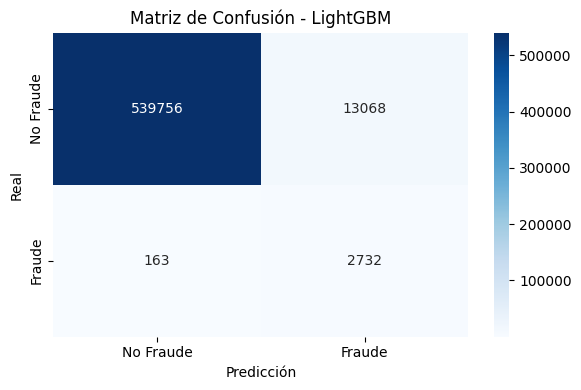

In [22]:
# -----------------------------
# Matriz de Confusión
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraude", "Fraude"], yticklabels=["No Fraude", "Fraude"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - LightGBM")
plt.tight_layout()
plt.show()

13,068 falsos positivos es considerablemente alto, lo cual puede llevar a que usuarios legítimos sean molestados o bloqueados erróneamente.



In [20]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
ratio_fp = (tp + fp) / tp if tp != 0 else float('inf')
print(f"Ratio FP: {ratio_fp:.2f}")

Ratio FP: 5.78


Por cada fraude real que el modelo detecta correctamente, hay aproximadamente 5.78 transacciones legítimas que son clasificadas como fraude por error.

### Métricas personalizadas

### 1. Penalización directa a Falsos Positivos (fp_penalty)

In [30]:
def fp_penalty(y_pred, train_data):
    y_true = train_data.get_label()
    y_pred_bin = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    penalty = fp / (tp + 1e-6)
    return 'fp_penalty', penalty, False  # False = metric lower is better

### 2. Ratio TP + FP sobre TP (fp_ratio_penalty)


In [31]:
def fp_ratio_penalty(y_pred, train_data):
    y_true = train_data.get_label()
    y_pred_bin = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    ratio = (tp + fp) / (tp + 1e-6)
    return 'fp_ratio_penalty', ratio, False


### 3. Balanced Recall-Weighted F1 (balanced_f1)

In [32]:
def balanced_f1(y_pred, train_data):
    y_true = train_data.get_label()
    y_pred_bin = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_bin)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    penalty = 1 - (fp / (fp + tn + 1e-6))
    return 'balanced_f1_penalty', f1 * penalty, True  # True = metric higher is better

In [48]:
import lightgbm as lgb
from lightgbm import Dataset, train
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --------------------------------------------
# Datos
# --------------------------------------------
train_data = Dataset(X_train, label=y_train)
val_data = Dataset(X_test, label=y_test)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 42,
    'class_weight': 'balanced'
}

# --------------------------------------------
# Lista para almacenar resultados
# --------------------------------------------
results = []

# --------------------------------------------
# Función general de entrenamiento y evaluación
# --------------------------------------------
def train_and_evaluate(feval_func, feval_name):
    print(f"\n📌 Entrenando con función: {feval_name}")

    model = train(
        params,
        train_data,
        valid_sets=[val_data],
        feval=feval_func,

    )

    y_proba = model.predict(X_test)
    y_pred = (y_proba > 0.5).astype(int)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    ratio_fp = (tp + fp) / tp if tp != 0 else float('inf')

    print(f"AUC: {auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"Ratio FP: {ratio_fp:.2f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraude", "Fraude"], yticklabels=["No Fraude", "Fraude"])
    plt.title(f"Matriz de Confusión - {feval_name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    results.append({
        'model': feval_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'ratio_fp': ratio_fp
    })

# --------------------------------------------
# Entrenar con cada función feval
# --------------------------------------------
train_and_evaluate(fp_penalty, "FP Penalty")
train_and_evaluate(fp_ratio_penalty, "FP Ratio Penalty")
train_and_evaluate(balanced_f1, "Balanced F1")

# --------------------------------------------
# Gráficas comparativas
# --------------------------------------------
results_df = pd.DataFrame(results)
models = results_df['model'].tolist()
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(18, 6))

# Precision y Recall
plt.subplot(1, 3, 1)
plt.bar(x - width/2, results_df['precision'], width, label='Precision', color='skyblue')
plt.bar(x + width/2, results_df['recall'], width, label='Recall', color='orange')
plt.xticks(x, models, rotation=45, ha='right')
plt.title("Precision y Recall por modelo")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()

# Ratio FP
plt.subplot(1, 3, 2)
plt.bar(models, results_df['ratio_fp'], color='red')
plt.xticks(rotation=45, ha='right')
plt.title("Ratio FP por modelo")
plt.ylabel("Ratio FP")

# AUC
plt.subplot(1, 3, 3)
plt.bar(models, results_df['auc'], color='green')
plt.xticks(rotation=45, ha='right')
plt.title("AUC por modelo")
plt.ylabel("AUC")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()



📌 Entrenando con función: FP Penalty
